# <center>Forest Cover Classification</center>
<center>If you liked this kernel and/or found it helpful, please upvote it so others can see it too!</center>

<img src="https://cdn-images-1.medium.com/max/500/1*QNtpWNresupHbiV7Xe59gg.png">

# The Forest Cover Type Challenge

From the competition's <a href="https://www.kaggle.com/c/forest-cover-type-kernels-only">overview page</a>:  

In this competition you are asked to predict the forest cover type (the predominant kind of tree cover) from cartographic variables. The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.



# Table of Contents
* [Config and Imports](#config_and_imports)<br>
* [Feature Overview](#feature_overview)<br>
* [Load and Explore Data](#load_and_explore_data)<br>
* [Visualize and Transform Data](#visualize_and_transform_data)<br>
* [Train Model](#train_model)<br>
* [Error Analysis](#error_analysis)<br>
* [Make Predictions on Test Set](#make_predictions)<br>
* [Next Steps](#next_steps)<br>

<a id='config_and_imports'></a>
# Config and Imports

In [1]:
# True to spend extra time displaying graphs, False for speedy results
show_plots = True

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<a id='feature_overview'></a>
#  Feature Overview
__Elevation__ - Elevation in meters<br>
__Aspect__ - Aspect in degrees azimuth<br>
__Slope__ - Slope in degrees<br>
__Horizontal_Distance_To_Hydrology__ - Horz Dist to nearest surface water features<br>
__Vertical_Distance_To_Hydrology__ - Vert Dist to nearest surface water features<br>
__Horizontal_Distance_To_Roadways__ - Horz Dist to nearest roadway<br>
__Hillshade_9am (0 to 255 index)__ - Hillshade index at 9am, summer solstice<br>
__Hillshade_Noon (0 to 255 index)__ - Hillshade index at noon, summer solstice<br>
__Hillshade_3pm (0 to 255 index)__ - Hillshade index at 3pm, summer solstice<br>
__Horizontal_Distance_To_Fire_Points__ - Horz Dist to nearest wildfire ignition points<br>
__Wilderness_Area__ (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation<br>
__Soil_Type__ (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation<br>
__Cover_Type__ (7 types, integers 1 to 7) - Forest Cover Type designation<br>

<a id='load_and_explore_data'></a>
# Load and Explore Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

In [5]:
train.describe()

Id     Elevation        Aspect         Slope  \
count  15120.00000  15120.000000  15120.000000  15120.000000   
mean    7560.50000   2749.322553    156.676653     16.501587   
std     4364.91237    417.678187    110.085801      8.453927   
min        1.00000   1863.000000      0.000000      0.000000   
25%     3780.75000   2376.000000     65.000000     10.000000   
50%     7560.50000   2752.000000    126.000000     15.000000   
75%    11340.25000   3104.000000    261.000000     22.000000   
max    15120.00000   3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000                        5.000000   
50%                          180.000000                       32.000000   
75%                          330.000000                       79.000000   
max                         1343.000000                      554.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                     15120.000000   15120.000000    15120.000000   
mean                       1714.023214     212.704299      218.965608   
std                        1325.066358      30.561287       22.801966   
min                           0.000000       0.000000       99.000000   
25%                         764.000000     196.000000      207.000000   
50%                        1316.000000     220.000000      223.000000   
75%                        2270.000000     235.000000      235.000000   
max                        6890.000000     254.000000      254.000000   

       Hillshade_3pm  ...   Soil_Type32   Soil_Type33   Soil_Type34  \
count   15120.000000  ...  15120.000000  15120.000000  15120.000000   
mean      135.091997  ...      0.045635      0.040741      0.001455   
std        45.895189  ...      0.208699      0.197696      0.038118   
min         0.000000  ...      0.000000      0.000000      0.000000   
25%       106.000000  ...      0.000000      0.000000      0.000000   
50%       138.000000  ...      0.000000      0.000000      0.000000   
75%       167.000000  ...      0.000000      0.000000      0.000000   
max       248.000000  ...      1.000000      1.000000      1.000000   

        Soil_Type35   Soil_Type36   Soil_Type37   Soil_Type38   Soil_Type39  \
count  15120.000000  15120.000000  15120.000000  15120.000000  15120.000000   
mean       0.006746      0.000661      0.002249      0.048148      0.043452   
std        0.081859      0.025710      0.047368      0.214086      0.203880   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        Soil_Type40    Cover_Type  
count  15120.000000  15120.000000  
mean       0.030357      4.000000  
std        0.171574      2.000066  
min        0.000000      1.000000  
25%        0.000000      2.000000  
50%        0.000000      4.000000  
75%        0.000000      6.000000  
max        1.000000      7.000000  

[8 rows x 56 columns]

In [6]:
train.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             232            148  ...            0   
1            220             235            151  ...            0   
2            234             238            135  ...            0   
3            238             238            122  ...            0   
4            220             234            150  ...            0   

   Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type38  Soil_Type39  Soil_Type40  Cover_Type  
0            0            0            0           5  
1            0            0            0           5  
2            0            0            0           2  
3            0            0            0           2  
4            0            0            0           5  

[5 rows x 56 columns]

<a id='visualize_and_transform_data'></a>
# Visualize and Transform Data

**Separate features by type**

In [7]:
target_classes = range(1,8)
target_class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', \
                      'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

numerical_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', \
                    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', \
                    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

categorical_features = [ 'Wilderness_Area', 'Soil_Type' ]

In [8]:
# extract target from data
y = train['Cover_Type']
train = train.drop('Cover_Type', axis=1)

**Plot distribution of target classes**

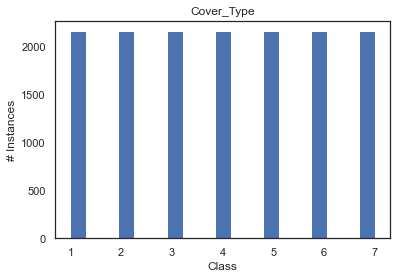

In [9]:
# plot target var
plt.hist(y, bins='auto')
plt.title('Cover_Type')
plt.xlabel('Class')
plt.ylabel('# Instances')
plt.show()

For each numerical feature, plot the variable distributions in the train and test sets. We want to make sure the distributions are similar in order to perform well on the test set.

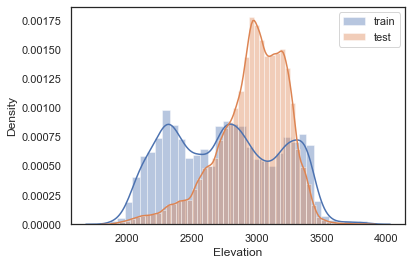

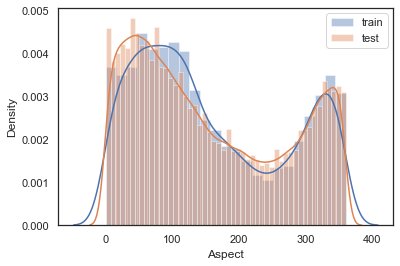

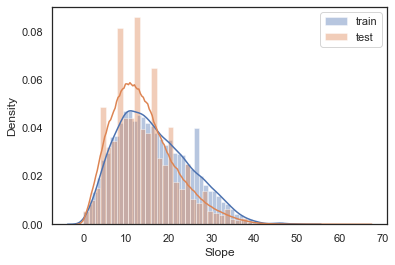

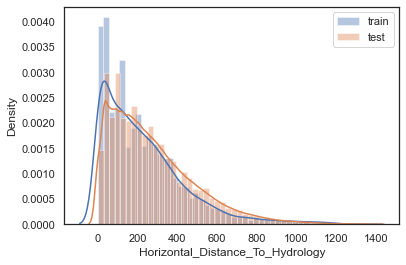

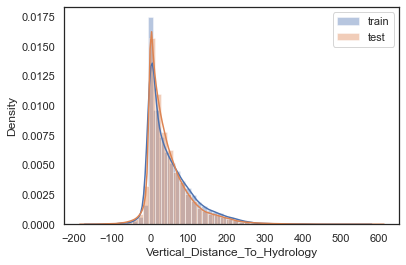

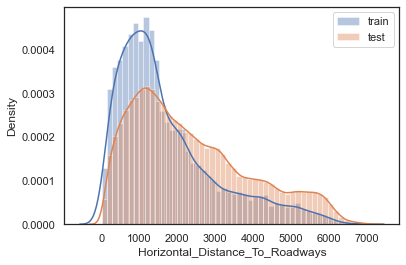

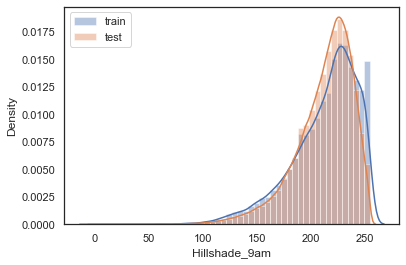

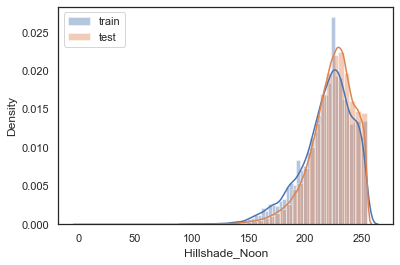

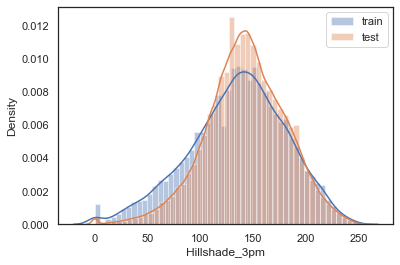

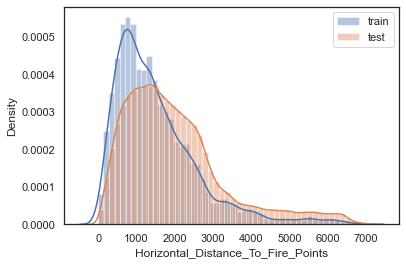

In [10]:
if show_plots:
    for feature_name in numerical_features:
        plt.figure()
        sns.distplot(train[feature_name], label='train')
        sns.distplot(test[feature_name], label='test')
        plt.legend()
        plt.show()

Specifically interesting to note that the train and test distributions for Elevation differ significantly. This could be a problem if Elevation is an important feature. Now let's do the same for categorical features (Wilderness and Soil Type).

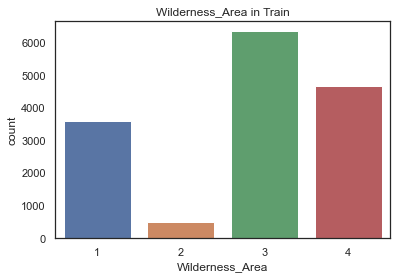

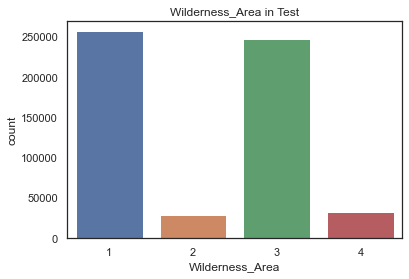

In [11]:
if show_plots:
    # categorical distributions btw train and test set
    train_wilderness_categorical = train['Wilderness_Area1'].copy().rename('Wilderness_Area')
    train_wilderness_categorical[train['Wilderness_Area2'] == 1] = 2
    train_wilderness_categorical[train['Wilderness_Area3'] == 1] = 3
    train_wilderness_categorical[train['Wilderness_Area4'] == 1] = 4

    test_wilderness_categorical = test['Wilderness_Area1'].copy().rename('Wilderness_Area')
    test_wilderness_categorical[test['Wilderness_Area2'] == 1] = 2
    test_wilderness_categorical[test['Wilderness_Area3'] == 1] = 3
    test_wilderness_categorical[test['Wilderness_Area4'] == 1] = 4

    plt.figure()
    sns.countplot(train_wilderness_categorical, label='train')
    plt.title('Wilderness_Area in Train')

    plt.figure()
    sns.countplot(test_wilderness_categorical, label='test')
    plt.title('Wilderness_Area in Test')

    plt.show()

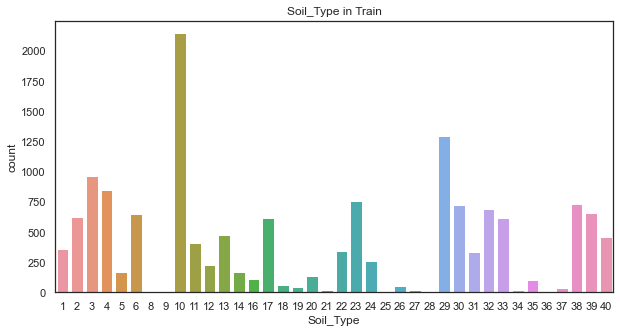

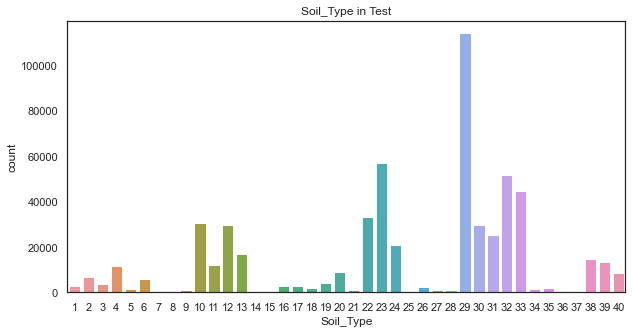

In [12]:
soil_classes = range(1,41)

train_soiltype_categorical = train['Soil_Type1'].copy().rename('Soil_Type')
for cl in soil_classes:
    train_soiltype_categorical[train['Soil_Type'+str(cl)] == 1] = cl

test_soiltype_categorical = test['Soil_Type1'].copy().rename('Soil_Type')
for cl in soil_classes:
    test_soiltype_categorical[test['Soil_Type'+str(cl)] == 1] = cl

plt.figure(figsize=(10, 5))
sns.countplot(train_soiltype_categorical, label='train')
plt.title('Soil_Type in Train')

plt.figure(figsize=(10, 5))
sns.countplot(test_soiltype_categorical, label='test')
plt.title('Soil_Type in Test')

plt.show()

**PCA**

In [13]:
pca = PCA(n_components=3)
train_pca = pca.fit_transform(train)
print('Representation of dataset in 3 dimensions:\n')
print(train_pca)

Representation of dataset in 3 dimensions:

[[ 7634.49851301  1512.00327677  4553.9727057 ]
 [ 7631.43746227  1382.06472919  4576.68207984]
 [ 7656.35578993  3631.44313691  2921.15233512]
 ...
 [-7572.46847156 -1217.53043388   580.05039112]
 [-7578.54325309 -1439.76718726   420.75338587]
 [-7579.84760167 -1425.55876028   389.36561977]]


In [14]:
if show_plots:
    # graph pca in interactive 3d chart
    # props to Roman Kovalenko's "Data distribution & 3D Scatter Plots" kernel for showing me where to find a good 3d graphing lib

    colors = ['red', 'blue', 'green', 'black', 'purple', 'orange', 'gray']
    # feel free to change the colors up - unfortunately there's usually a tradeoff between aesthetics and readability
    # colors = ['#f45f42', '#f49241', '#db6a0d', '#dba00d', '#ead40e', '#ffb163', '#ea480e']

    traces = []

    # iterate over classes and add each set of points to traces list
    for cl in target_classes:

        # get all 3-d pca vectors that match the current class
        class_pca = train_pca[y[y == cl].index.values]

        class_pca_x = [ pt[0] for pt in class_pca]
        class_pca_y = [ pt[1] for pt in class_pca]
        class_pca_z = [ pt[2] for pt in class_pca]

        trace = go.Scatter3d(
            x=class_pca_x,
            y=class_pca_y,
            z=class_pca_z,
            mode='markers',
            marker=dict(
                color=colors[cl-1],
                size=3
            ),
            name=target_class_names[cl-1]
        )

        traces.append(trace)

    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=traces, layout=layout)
    py.iplot(fig, filename='simple-3d-scatter')

Looks like the classes are pretty intertwined, but there are definitely patterns emerging. Let's handle the data a bit more before training a model!

**Feature Engineering**

In [15]:
# drop uninformative features
train = train.drop('Id', axis=1)

Now we'll add the following features:
* Euclidean distance to hydrology
* Mean distance to amenities (fire points, hydrology, and roadways)
* Elevation minus vertical distance to hydrology

Disclaimer: these features were inspired by Lathwal's excellent public kernel. I have left out a few features so you can check his out for the full set!

In [16]:
# write a function to transform the train and test sets
# we'll also append an underscore "_" to our engineered feature names to help differentiate them
def add_features(data):
    data['Euclidean_Distance_To_Hydrology_'] = (data['Horizontal_Distance_To_Hydrology']**2 + data['Vertical_Distance_To_Hydrology']**2)**0.5
    data['Mean_Distance_To_Amenities_'] = (data['Horizontal_Distance_To_Fire_Points'] + data['Horizontal_Distance_To_Hydrology'] + data['Horizontal_Distance_To_Roadways']) / 3.0
    data['Elevation_Minus_Vertical_Distance_To_Hydrology_'] = data['Elevation'] - data['Vertical_Distance_To_Hydrology']
    return data

train = add_features(train)
test = add_features(test)

Additionally, I wrote code to convert the angle in degrees (circular, aka 0 = 360) to their cos and sin components - however, the code is commented because it actually lowered performance. Perhaps there was some bias in assigning certain angles which contains information that is lost when it is approximated as cos and sin.

In [17]:
# # convert aspect angle in degrees to cos + sin
# train['AspectCos'] = train['Aspect']
# train['AspectSin'] = train['Aspect']

# train['AspectCos'] = train['AspectCos'].apply(lambda x: np.cos(np.deg2rad(x)))
# train['AspectSin'] = train['AspectSin'].apply(lambda x: np.sin(np.deg2rad(x)))

# train = train.drop(['Aspect'], axis=1)

**Feature Correlations**

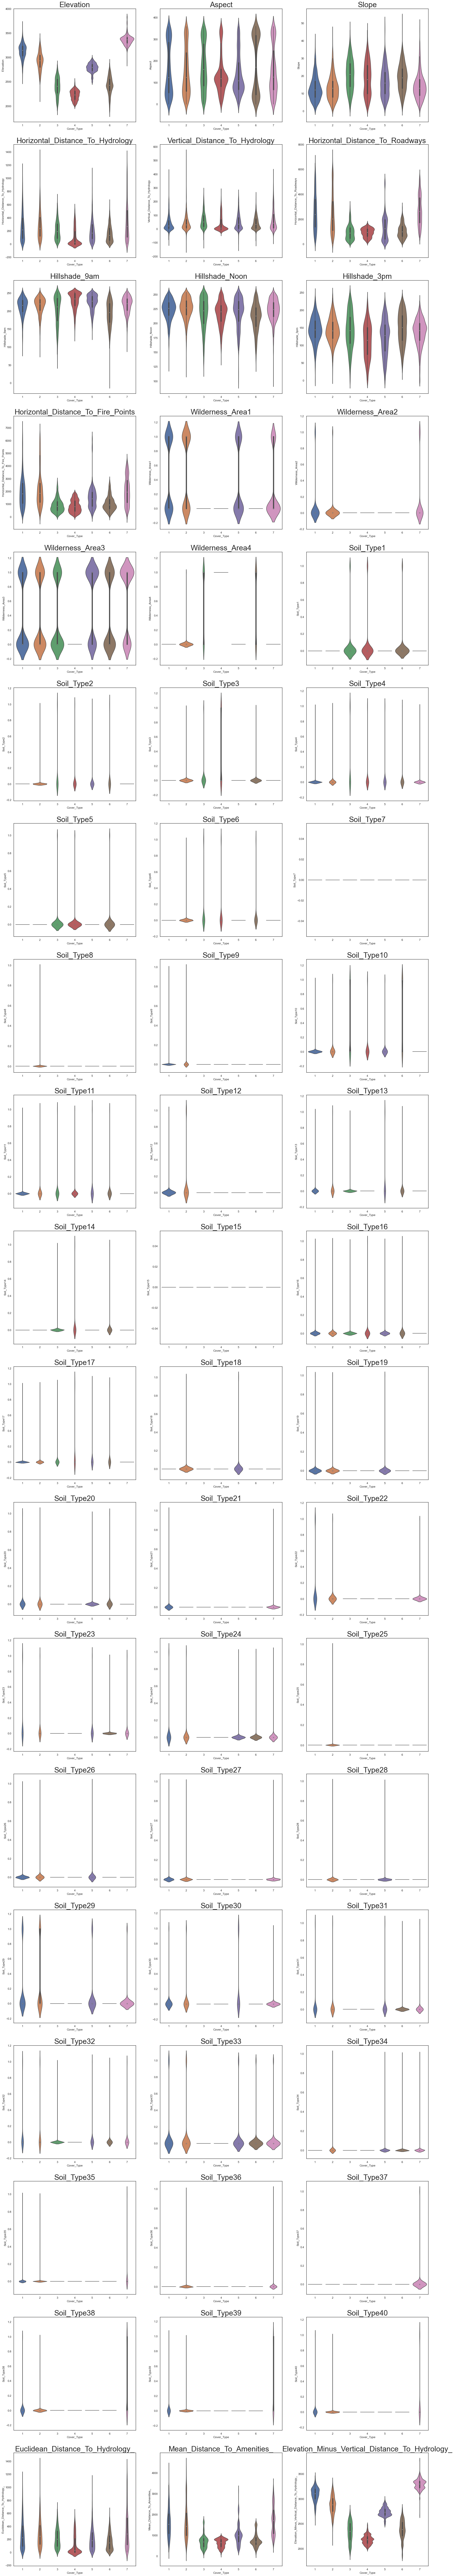

In [18]:
if show_plots:
    # plot each feature (y axis) with target (x axis)
    plt.figure(figsize=(30, 190))

    # iterate through feature names and assign to pyplot subplot
    for i,feature_name in enumerate(train.columns.values):
        plt.subplot(19,3,i+1)
        sns.violinplot(y, train[feature_name])
        plt.title(feature_name, fontsize=30)

    plt.show()

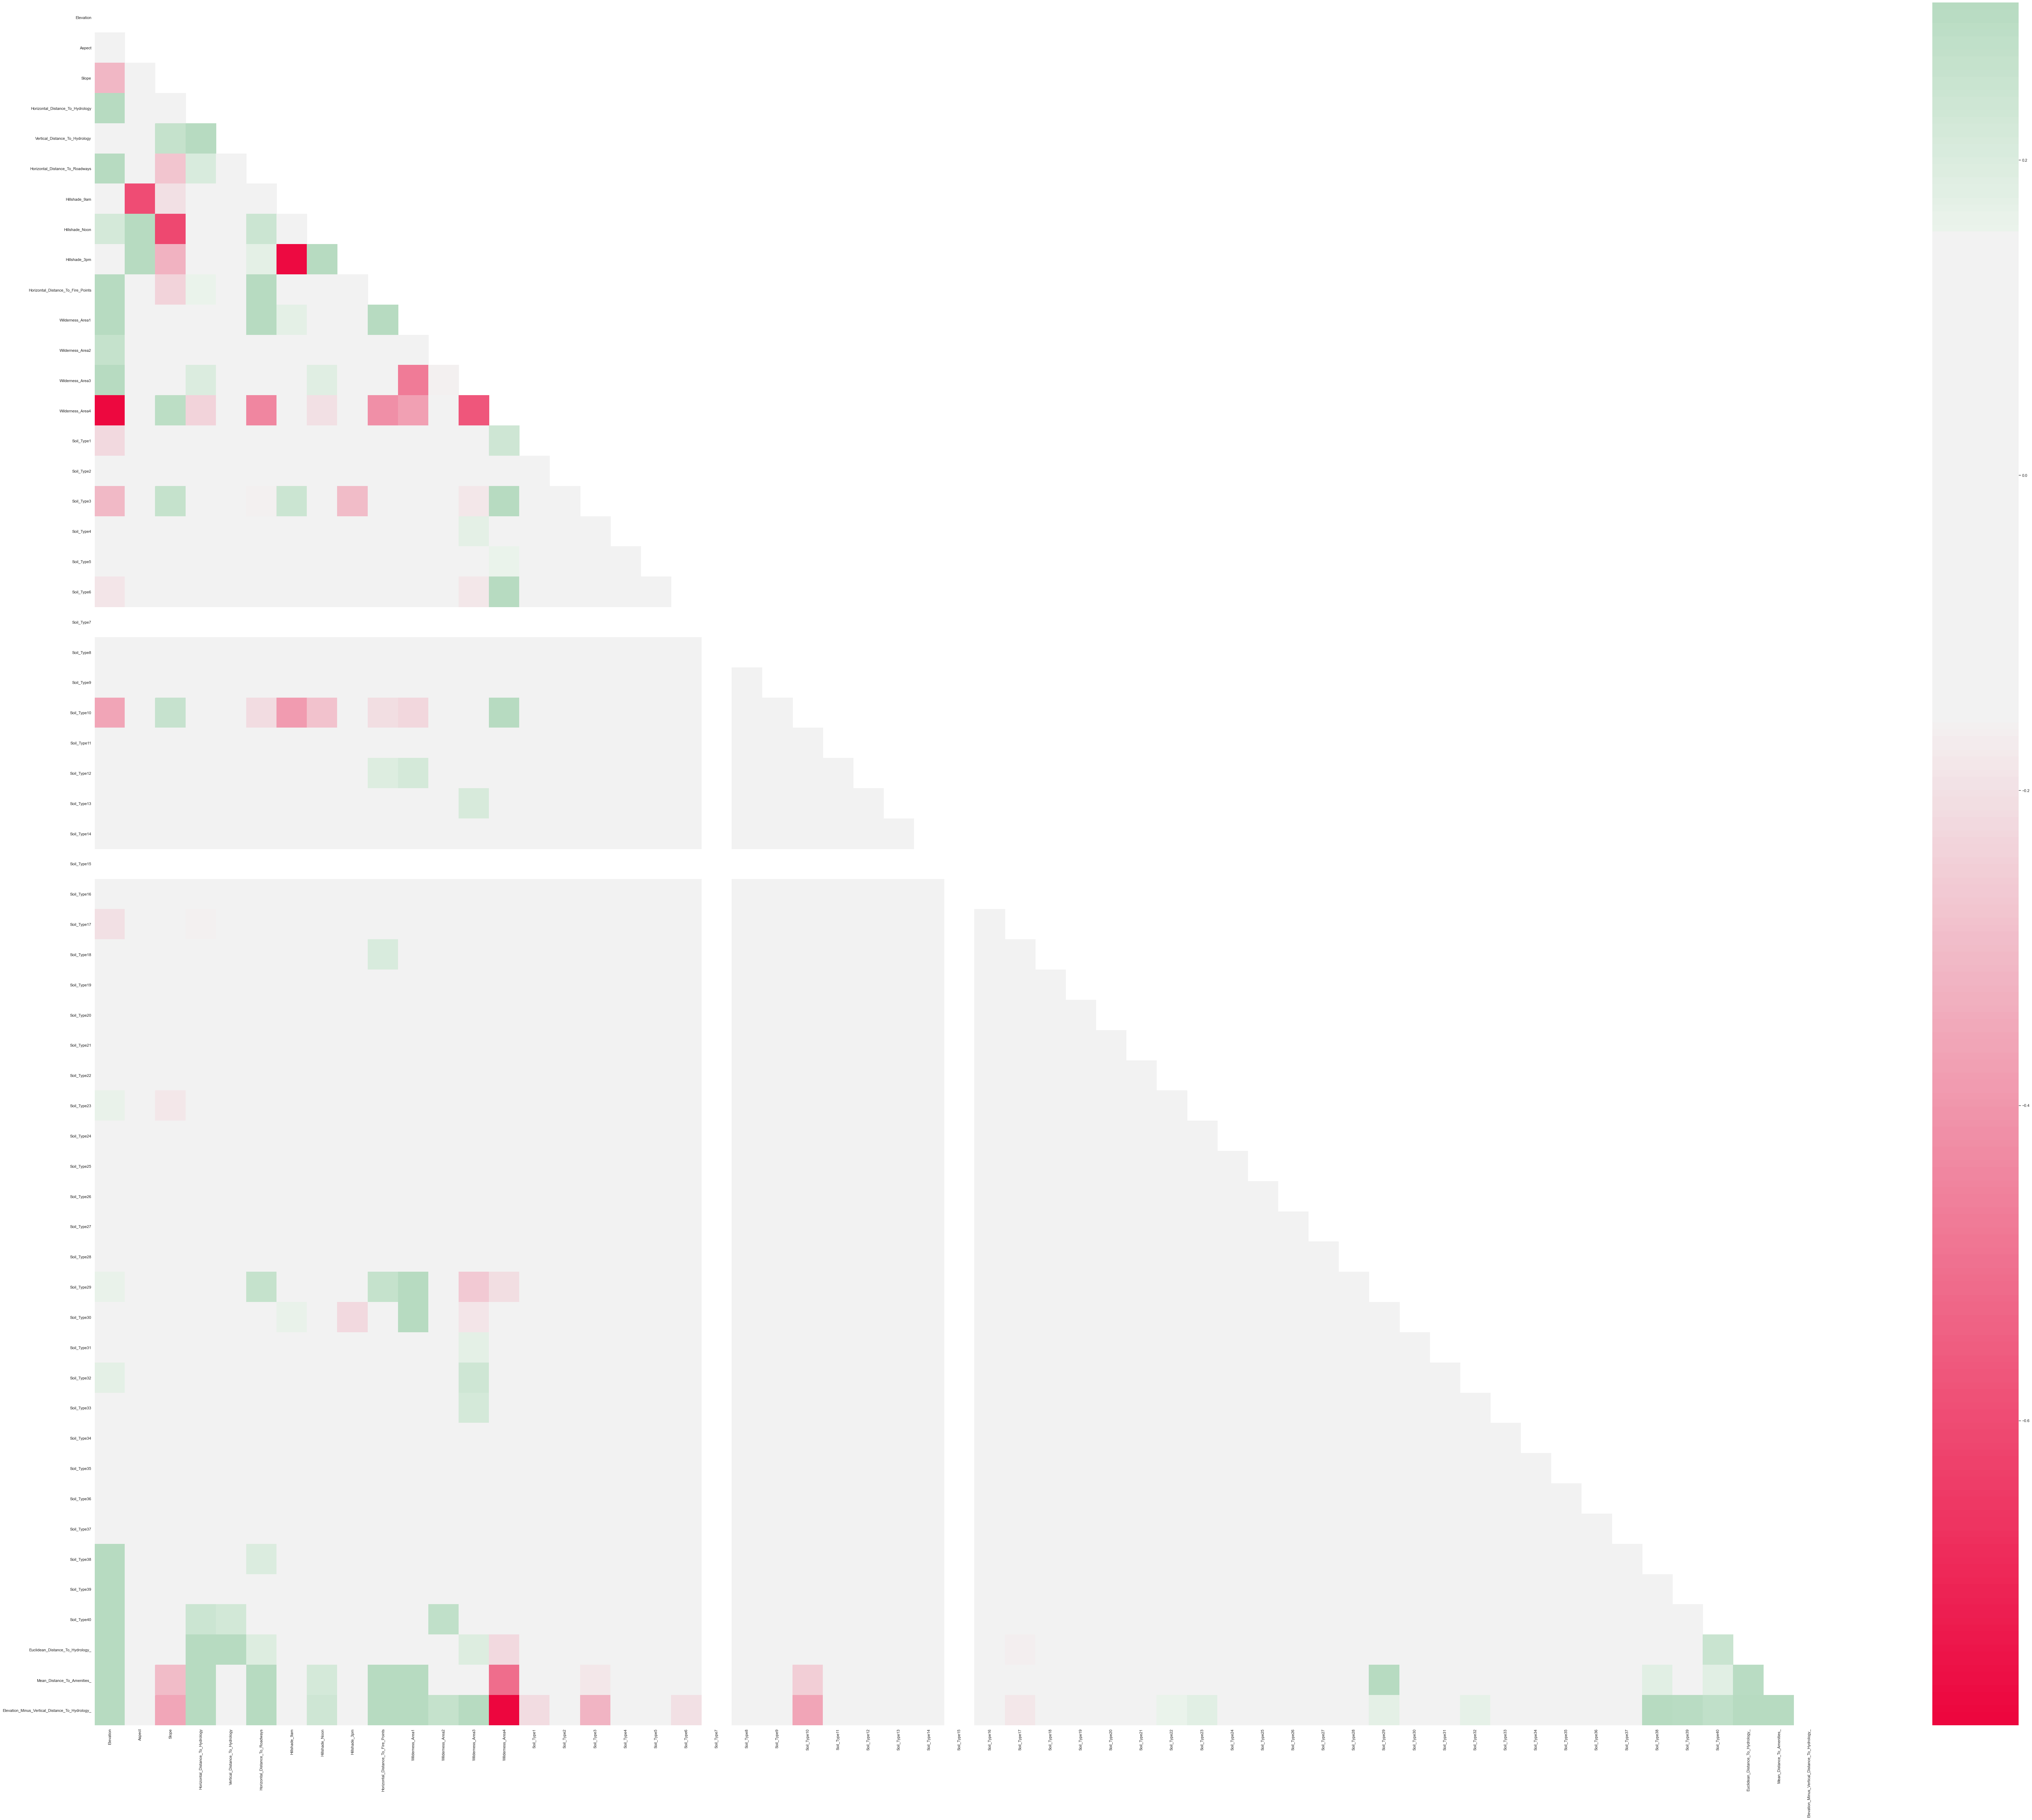

In [19]:
if show_plots:

    # Compute the correlation matrix
    corr = train.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(110, 90))

    # Generate a custom diverging colormap, use the line below to customize your color options
    # sns.choose_diverging_palette()
    cmap = sns.diverging_palette(8,132,99,50,50,9, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0)

    # since the heatmap is very large, use following line to save to png for close examination
    # sns_heatmap.get_figure().savefig("corr_heatmap.png")

Since we have so many features, it's really hard to read those features. There's a line of code in the previous cell to save this graphic to a CSV to take a closer look.

From this graph we can draw a couple conclusions:
* A couple of soil types show up as white, because they're actually entirely uniform, and thus useless.
* Almost no correlation among soil types.
* There is some correlation among the Hillshade times, as well as Slope and Elevation.

<a id='train_model'></a>
# Train Model

Nothing out of the ordinary here. Split into training and holdout sets, train a model, and plot feature importance. 

Originally I used Random Forest, but I switched to ExtraTreesClassifier because it generalizes better. I use n_estimators=500 for decent time/performance tradeoff.

In [20]:
# split data into train and test sets, using constant random state to better quantify our changes
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=1)

In [21]:
# train model
model = ExtraTreesClassifier(n_estimators=500)
model.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=500)

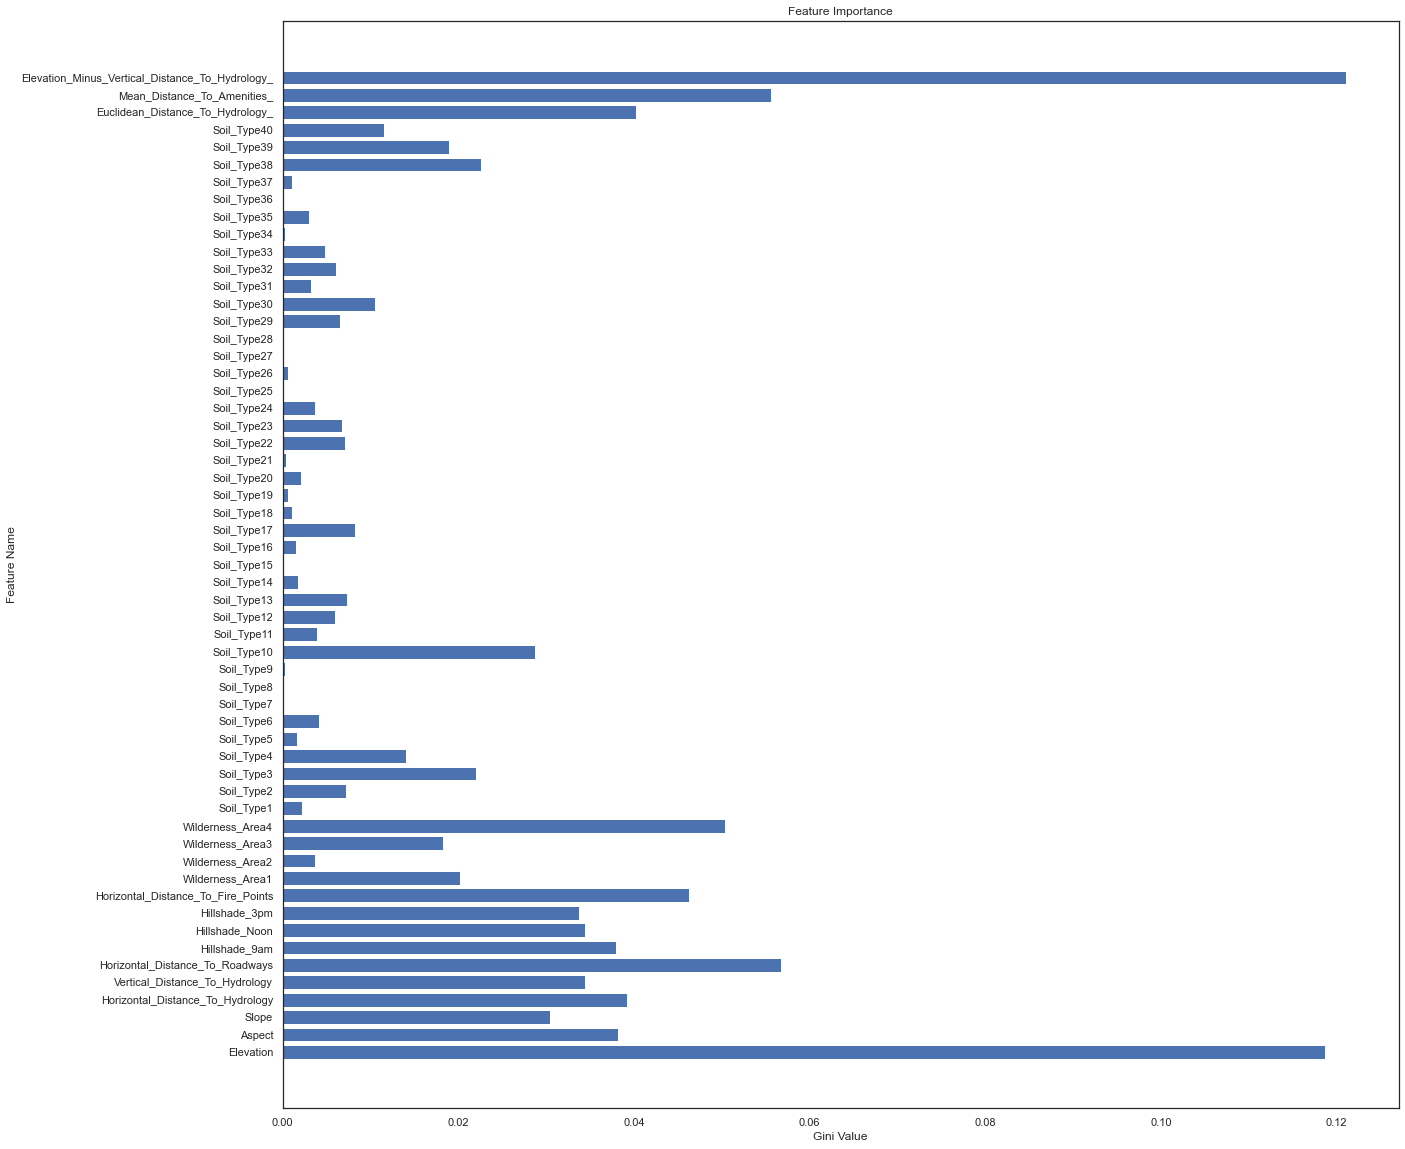

In [22]:
# plot feature importance
plt.figure(figsize=(20,20))
plt.barh(X_train.columns.values, model.feature_importances_)
plt.title('Feature Importance')
plt.ylabel('Feature Name')
plt.xlabel('Gini Value')
plt.show()

In [23]:
# make predictions on the cross validation set
y_pred = model.predict(X_test)
n_correct = (y_pred == y_test).sum()
n_total = (y_pred == y_test).count()
print('Accuracy:', n_correct/n_total)

Accuracy: 0.8779559118236473


<a id='error_analysis'></a>
# Error Analysis

In [24]:
# table with data points, truth, and pred
errors = X_test.copy()
errors['truth'] = y_test
errors['pred'] = y_pred
errors = errors[errors['truth'] != errors['pred']]

In [25]:
print(errors.shape[0], 'errors over',y_pred.shape[0],'predictions')

609 errors over 4990 predictions


In [26]:
errors.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
11340       2696       4     13                                30   
1070        3001      57     18                               180   
8497        2655     133     20                               180   
13875       2680      31     11                               120   
3191        2126       2     36                                30   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
11340                              10                             2800   
1070                               28                             4673   
8497                               21                             2312   
13875                               9                             2105   
3191                               15                              618   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
11340            202             214            148   
1070             229             200             97   
8497             247             226             97   
13875            217             215            132   
3191             146             147            120   

       Horizontal_Distance_To_Fire_Points  ...  Soil_Type36  Soil_Type37  \
11340                                6524  ...            0            0   
1070                                 1864  ...            0            0   
8497                                 2398  ...            0            0   
13875                                1902  ...            0            0   
3191                                  417  ...            0            0   

       Soil_Type38  Soil_Type39  Soil_Type40  \
11340            0            0            0   
1070             0            0            0   
8497             0            0            0   
13875            0            0            0   
3191             0            0            0   

       Euclidean_Distance_To_Hydrology_  Mean_Distance_To_Amenities_  \
11340                         31.622777                  3118.000000   
1070                         182.164761                  2239.000000   
8497                         181.220860                  1630.000000   
13875                        120.337027                  1375.666667   
3191                          33.541020                   355.000000   

       Elevation_Minus_Vertical_Distance_To_Hydrology_  truth  pred  
11340                                             2686      1     2  
1070                                              2973      1     2  
8497                                              2634      5     3  
13875                                             2671      5     6  
3191                                              2111      3     6  

[5 rows x 59 columns]

In [27]:
errors.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   609.000000  609.000000  609.000000                        609.000000   
mean   2798.361248  148.602627   15.188834                        215.753695   
std     354.002269  112.034460    7.727821                        198.984193   
min    1944.000000    0.000000    0.000000                          0.000000   
25%    2534.000000   54.000000   10.000000                         60.000000   
50%    2846.000000  120.000000   15.000000                        162.000000   
75%    3081.000000  244.000000   20.000000                        313.000000   
max    3473.000000  359.000000   39.000000                       1082.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      609.000000                       609.000000   
mean                        43.735632                      1955.998358   
std                         59.243677                      1472.246662   
min                       -146.000000                         0.000000   
25%                          5.000000                       859.000000   
50%                         23.000000                      1452.000000   
75%                         62.000000                      2758.000000   
max                        363.000000                      6679.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     609.000000      609.000000     609.000000   
mean      212.577997      219.771757     137.553366   
std        27.923667       21.420035      38.953424   
min        97.000000      127.000000       0.000000   
25%       197.000000      207.000000     112.000000   
50%       219.000000      222.000000     140.000000   
75%       233.000000      236.000000     162.000000   
max       254.000000      254.000000     247.000000   

       Horizontal_Distance_To_Fire_Points  ...  Soil_Type36  Soil_Type37  \
count                          609.000000  ...        609.0        609.0   
mean                          1639.175698  ...          0.0          0.0   
std                           1194.940631  ...          0.0          0.0   
min                             42.000000  ...          0.0          0.0   
25%                            816.000000  ...          0.0          0.0   
50%                           1355.000000  ...          0.0          0.0   
75%                           2190.000000  ...          0.0          0.0   
max                           6576.000000  ...          0.0          0.0   

       Soil_Type38  Soil_Type39  Soil_Type40  \
count   609.000000    609.00000   609.000000   
mean      0.024631      0.01642     0.008210   
std       0.155124      0.12719     0.090311   
min       0.000000      0.00000     0.000000   
25%       0.000000      0.00000     0.000000   
50%       0.000000      0.00000     0.000000   
75%       0.000000      0.00000     0.000000   
max       1.000000      1.00000     1.000000   

       Euclidean_Distance_To_Hydrology_  Mean_Distance_To_Amenities_  \
count                        609.000000                   609.000000   
mean                         222.956842                  1270.309250   
std                          204.585385                   765.748250   
min                            0.000000                   102.333333   
25%                           62.096699                   683.666667   
50%                          171.058470                  1056.666667   
75%                          327.391203                  1659.333333   
max                         1112.800072                  4063.666667   

       Elevation_Minus_Vertical_Distance_To_Hydrology_       truth        pred  
count                                       609.000000  609.000000  609.000000  
mean                                       2754.625616    2.707718    3.438424  
std                                         354.939442    1.764029    2.038261  
min                               

Let's try subtracting the descriptive statistics for all train data from those of the errors. This may help us spot trends (features that are underperforming).

In [28]:
errors.describe() - train.describe()

Aspect     Elevation  \
count -14511.000000 -14511.000000   
mean      -8.074026     49.038695   
std        1.948658    -63.675919   
min        0.000000     81.000000   
25%      -11.000000    158.000000   
50%       -6.000000     94.000000   
75%      -17.000000    -23.000000   
max       -1.000000   -376.000000   

       Elevation_Minus_Vertical_Distance_To_Hydrology_  \
count                                    -14511.000000   
mean                                         56.379584   
std                                         -59.740586   
min                                         102.000000   
25%                                         164.000000   
50%                                          92.000000   
75%                                         -22.000000   
max                                        -310.000000   

       Euclidean_Distance_To_Hydrology_  Hillshade_3pm  Hillshade_9am  \
count                     -14511.000000  -14511.000000  -14511.000000   
mean                         -12.991937       2.461369      -0.126302   
std                          -10.906310      -6.941764      -2.637620   
min                            0.000000       0.000000      97.000000   
25%                           -5.089609       6.000000       1.000000   
50%                          -17.422299       2.000000      -1.000000   
75%                          -14.677867      -5.000000      -2.000000   
max                         -244.139499      -1.000000       0.000000   

       Hillshade_Noon  Horizontal_Distance_To_Fire_Points  \
count   -14511.000000                       -14511.000000   
mean         0.806149                          128.028410   
std         -1.381931                           95.004139   
min         28.000000                           42.000000   
25%          0.000000                           86.000000   
50%         -1.000000                           99.000000   
75%          1.000000                          201.750000   
max          0.000000                         -417.000000   

       Horizontal_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  ...  \
count                     -14511.000000                    -14511.000000  ...   
mean                         -11.442006                       241.975144  ...   
std                          -11.091103                       147.180304  ...   
min                            0.000000                         0.000000  ...   
25%                           -7.000000                        95.000000  ...   
50%                          -18.000000                       136.000000  ...   
75%                          -17.000000                       488.000000  ...   
max                         -261.000000                      -211.000000  ...   

       Soil_Type7    Soil_Type8    Soil_Type9  Vertical_Distance_To_Hydrology  \
count    -14511.0 -14511.000000 -14511.000000                   -14511.000000   
mean          0.0     -0.000066     -0.000661                       -7.340889   
std           0.0     -0.008133     -0.025710                       -1.995730   
min           0.0      0.000000      0.000000                        0.000000   
25%           0.0      0.000000      0.000000                        0.000000   
50%           0.0      0.000000      0.000000                       -9.000000   
75%           0.0      0.000000      0.000000                      -17.000000   
max           0.0     -1.000000     -1.000000                     -191.000000   

       Wilderness_Area1  Wilderness_Area2  Wilderness_Area3  Wilderness_Area4  \
count     -14511.000000     -14511.000000     -14511.000000     -14511.000000   
mean           0.034681          0.001480          0.054641         -0.090802   
std            0.019842          0.003966          0.006202         -0.048683   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50

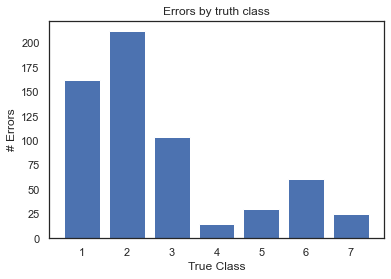

In [29]:
# x: classes y: # errors
error_truths = []
for cl in target_classes:
    error_count = errors[errors['truth'] == cl]['truth'].count()
    error_truths.append(error_count)
    
plt.bar(target_classes, error_truths)
plt.title('Errors by truth class')
plt.xlabel('True Class')
plt.ylabel('# Errors')
plt.show()

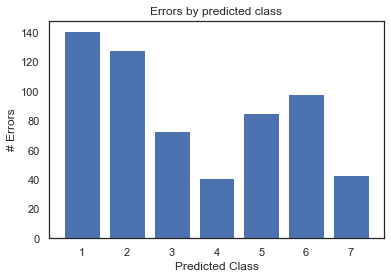

In [30]:
# x: classes y: # errors
error_preds = []
for cl in target_classes:
    error_count = errors[errors['pred'] == cl]['pred'].count()
    error_preds.append(error_count)
    
plt.bar(target_classes, error_preds)
plt.title('Errors by predicted class')
plt.xlabel('Predicted Class')
plt.ylabel('# Errors')
plt.show()

Let's make a confusion matrix to visualize where our errors are coming from.

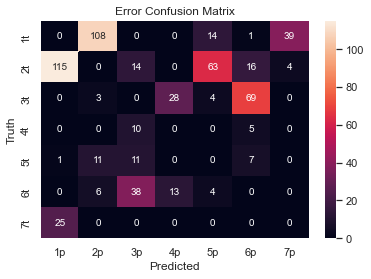

In [31]:
cf_matrix = confusion_matrix(errors['truth'], errors['pred'])

cfm_df = pd.DataFrame(cf_matrix, index = [str(cl)+'t' for cl in target_classes],
                  columns = [str(cl)+'p' for cl in target_classes])

ax = plt.axes()
sns.heatmap(cfm_df, annot=True, fmt='g', ax=ax)
ax.set_title('Error Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Looks like most of the errors are because of:
* Class 1 misclassified as Class 2, and vice versa
* Class 3 missclassified as Class 6
* Class 2 misclassified as Class 5

<a id='make_predictions'></a>
# Make predictions on test set

In [32]:
prediction_classes = pd.Series(model.predict(test.drop('Id', axis=1))).rename('Cover_Type')
predictions = pd.concat([test['Id'], prediction_classes], axis=1).reset_index().drop('index', axis=1)
predictions.to_csv('submission.csv', index=False)
predictions.head()

Id  Cover_Type
0  15121           2
1  15122           2
2  15123           2
3  15124           2
4  15125           2

<a id='next_steps'></a>
# Next Steps
1. Try to minimize misclassifications between:
    - class 1 and class 2
    - class 3 and class 6
2. Convert soil type descriptions to categorical features
3. Downsample train set to closer resemble feature distribution of test set - especially for elevation, which seems to be one of the most important features, but has the highest mismatch